In [72]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from scipy import stats

sns.set_theme()

print("Seaborn: {}".format(sns.__version__))
print("NumPy: {}".format(np.__version__))

Seaborn: 0.11.0
NumPy: 1.17.4


In [3]:
# Usable list

info = ["SEX","EDUCATION","MARRIAGE","AGE"]
delay_n = ["PAY_APR", "PAY_MAY", "PAY_JUN", "PAY_JUL", "PAY_AUG", "PAY_SEP"]
bill_n = ["BILL_AMT_APR", "BILL_AMT_MAY", "BILL_AMT_JUN", "BILL_AMT_JUL", "BILL_AMT_AUG", "BILL_AMT_SEP"]
pay_n = ["PAY_AMT_APR", "PAY_AMT_MAY", "PAY_AMT_JUN", "PAY_AMT_JUL", "PAY_AMT_AUG", "PAY_AMT_SEP"]

In [4]:
train = pd.read_csv("C:/Users/chowonjae/Desktop/내부 프로젝트/uci_creditcard-train-0.0-0.0 (1).csv")
test = pd.read_csv("C:/Users/chowonjae/Desktop/내부 프로젝트/uci_creditcard-test-0.0-0.0 (1).csv")

length = len(train)

rename_dict =  {"default payment next month":"default", 
                                "PAY_6" : "PAY_APR", 
                                "PAY_5" : "PAY_MAY", 
                                "PAY_4" : "PAY_JUN",  
                                "PAY_3" : "PAY_JUL",
                                "PAY_2": "PAY_AUG", 
                                "PAY_0": "PAY_SEP", 
                                "PAY_AMT6": "PAY_AMT_APR", 
                                "PAY_AMT5": "PAY_AMT_MAY", 
                                "PAY_AMT4": "PAY_AMT_JUN",
                                "PAY_AMT3": "PAY_AMT_JUL", 
                                "PAY_AMT2": "PAY_AMT_AUG", 
                                "PAY_AMT1": "PAY_AMT_SEP", 
                                "BILL_AMT6": "BILL_AMT_APR", 
                                "BILL_AMT5": "BILL_AMT_MAY", 
                                "BILL_AMT4": "BILL_AMT_JUN", 
                                "BILL_AMT3": "BILL_AMT_JUL", 
                                "BILL_AMT2": "BILL_AMT_AUG",
                                "BILL_AMT1": "BILL_AMT_SEP"}

#Change the column name "default payment next month" -> "default"
train = train.rename(columns = rename_dict)
test = test.rename(columns = rename_dict)

train = train.drop(["ID","sep_idx"], axis = 1)
train_drop_info = train.drop(info, axis = 1)

test = test.drop(["ID","sep_idx"], axis = 1)

# Change Type

train["SEX"] = train["SEX"].astype(np.int)
train["EDUCATION"] = train["EDUCATION"].astype(np.int)
train["MARRIAGE"] = train["MARRIAGE"].astype(np.int)
train["AGE"] = train["AGE"].astype(np.int)
train["default"] = train["default"].astype(np.int)
train[delay_n] = train[delay_n].astype(np.int)

test["SEX"] = test["SEX"].astype(np.int)
test["EDUCATION"] = test["EDUCATION"].astype(np.int)
test["MARRIAGE"] = test["MARRIAGE"].astype(np.int)
test["AGE"] = test["AGE"].astype(np.int)
test["default"] = test["default"].astype(np.int)
test[delay_n] = test[delay_n].astype(np.int)

In [5]:
train.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_SEP,PAY_AUG,PAY_JUL,PAY_JUN,PAY_MAY,...,BILL_AMT_JUN,BILL_AMT_MAY,BILL_AMT_APR,PAY_AMT_SEP,PAY_AMT_AUG,PAY_AMT_JUL,PAY_AMT_JUN,PAY_AMT_MAY,PAY_AMT_APR,default
0,120000.0,2,2,2,26,-1,2,0,0,0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
1,90000.0,2,2,2,34,0,0,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
2,50000.0,2,2,1,37,0,0,0,0,0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
3,50000.0,1,1,2,37,0,0,0,0,0,...,19394.0,19619.0,20024.0,2500.0,1815.0,657.0,1000.0,1000.0,800.0,0
4,140000.0,2,3,1,28,0,0,2,0,0,...,12211.0,11793.0,3719.0,3329.0,0.0,432.0,1000.0,1000.0,1000.0,0


## Correlation of Monthly Data

- PAY_n, BILL_AMT_n, PAY_AMT_n 데이터는 월별로 연관관계가 있는 데이터라고 생각함.
- 상관계수와 선형 회귀분석으로 연관관계가 있는지 파악.

In [110]:
## data

apr = ["BILL_AMT_APR", "PAY_AMT_APR"]
may = ["BILL_AMT_MAY", "PAY_AMT_MAY"]
jun = ["BILL_AMT_JUN", "PAY_AMT_JUN"]
jul = ["BILL_AMT_JUL", "PAY_AMT_JUL"]
aug = ["BILL_AMT_AUG", "PAY_AMT_AUG"]
sep = ["BILL_AMT_SEP", "PAY_AMT_SEP"]
month_list = [apr, may, jun, jul, aug, sep]

In [104]:
def month_Correlation(X, y, data = train, month = 1, log_transformation = False): 
    R_square_list = []
    if log_transformation:
        fig, ax = plt.subplots(2, round((6 - month + 1)/2), figsize = (12, 6))
        ax = ax.flatten()
        
        for i in range(6 - month):
            month_to_month = data[[X[i], y[i]]]
            log_month_to_month = np.log(month_to_month - np.min(month_to_month) + 1)

            X_data = log_month_to_month[X[i]].to_numpy().reshape(-1,1)
            y_data = log_month_to_month[y[i]].to_numpy()

            sns.scatterplot(x = X[i], y = y[i], data = log_month_to_month, ax = ax[i])
            ax[i].set_xlabel(X[i])
            ax[i].set_ylabel(y[i])

            lr = LinearRegression()
            lr.fit(X_data, y_data)

            lr_coef = lr.coef_
            lr_intercept = lr.intercept_
            lr_R_square = lr.score(X_data, y_data)
            R_square_list.append(lr_R_square)
            
            X2 = sm.add_constant(log_month_to_month[X[i]])
            est = sm.OLS(log_month_to_month[y[i]], X2)
            est2 = est.fit()
            print("log {} vs log {}".format(X[i], y[i]))
            print(est2.summary())
            
            ax[i].set_title("log {} vs log {} \n y = {:.3f} + {:.3f} * X".format(X[i], y[i], lr_intercept, lr_coef[0]))
            ax[i].plot(X_data, lr_intercept + lr_coef * X_data, color = 'k')
        
        
    else:
        fig, ax = plt.subplots(2, round((6 - month + 1)/2), figsize = (12, 6))
        ax = ax.flatten()
        
        for i in range(6 - month):
            month_to_month = data[[X[i], y[i]]]

            X_data = month_to_month[X[i]].to_numpy().reshape(-1,1)
            y_data = month_to_month[y[i]].to_numpy()

            sns.scatterplot(x = X[i], y = y[i], data = month_to_month, ax = ax[i])
            ax[i].set_xlabel(X[i])
            ax[i].set_ylabel(y[i])

            lr = LinearRegression()
            lr.fit(X_data, y_data)

            lr_coef = lr.coef_
            lr_intercept = lr.intercept_
            lr_R_square = lr.score(X_data, y_data)
            R_square_list.append(lr_R_square)
            
            X2 = sm.add_constant(month_to_month[X[i]])
            est = sm.OLS(month_to_month[y[i]], X2)
            est2 = est.fit()
            print("{} vs {}".format(X[i], y[i]))
            print(est2.summary())
            
            ax[i].set_title("{} vs {} \n y = {:.3f} + {:.3f} * X".format(X[i], y[i], lr_intercept, lr_coef[0]))
            ax[i].plot(X_data, lr_intercept + lr_coef * X_data, color = 'k')
        
    plt.tight_layout()
    plt.show()
    
    return R_square_list

BILL_AMT_APR vs BILL_AMT_MAY
                            OLS Regression Results                            
Dep. Variable:           BILL_AMT_MAY   R-squared:                       0.901
Model:                            OLS   Adj. R-squared:                  0.901
Method:                 Least Squares   F-statistic:                 2.195e+05
Date:                Tue, 01 Dec 2020   Prob (F-statistic):               0.00
Time:                        15:51:58   Log-Likelihood:            -2.7060e+05
No. Observations:               23996   AIC:                         5.412e+05
Df Residuals:                   23994   BIC:                         5.412e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const         2779.

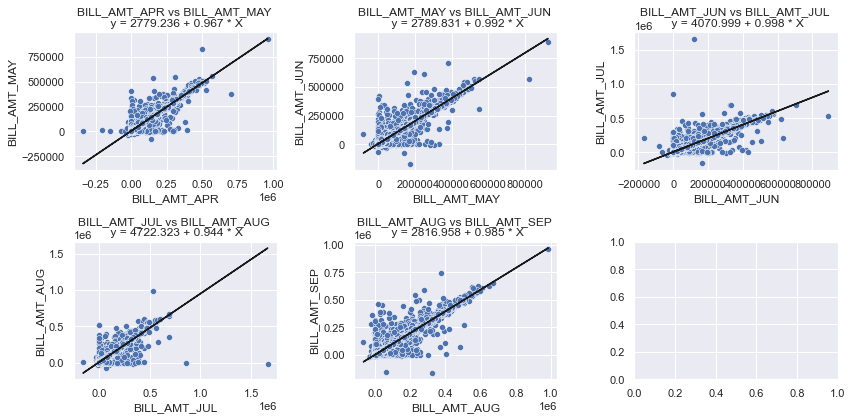

In [105]:
R_square_list = month_Correlation(X = bill_n[0:5], y = bill_n[1:6], data = train, month = 1, log_transformation = False)

In [67]:
for i in range( len(R_square_list)):
    X = bill_n[0:5]
    y = bill_n[1:6]
    print("{} vs {}:    R_square = {:.3f} \n".format(X[i], y[i], R_square_list[i]))

BILL_AMT_APR vs BILL_AMT_MAY:    R_square = 0.901 

BILL_AMT_MAY vs BILL_AMT_JUN:    R_square = 0.891 

BILL_AMT_JUN vs BILL_AMT_JUL:    R_square = 0.850 

BILL_AMT_JUL vs BILL_AMT_AUG:    R_square = 0.854 

BILL_AMT_AUG vs BILL_AMT_SEP:    R_square = 0.903 



- 전 달과 다음달의 BILL_AMT의 값은 선형관계가 있다는 것을 볼 수 있다. R_square값도 매우 높은 것을 볼 수 있다.

PAY_AMT_APR vs PAY_AMT_MAY
                            OLS Regression Results                            
Dep. Variable:            PAY_AMT_MAY   R-squared:                       0.026
Model:                            OLS   Adj. R-squared:                  0.026
Method:                 Least Squares   F-statistic:                     635.8
Date:                Tue, 01 Dec 2020   Prob (F-statistic):          1.74e-138
Time:                        15:52:04   Log-Likelihood:            -2.6494e+05
No. Observations:               23996   AIC:                         5.299e+05
Df Residuals:                   23994   BIC:                         5.299e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const        4062.3840 

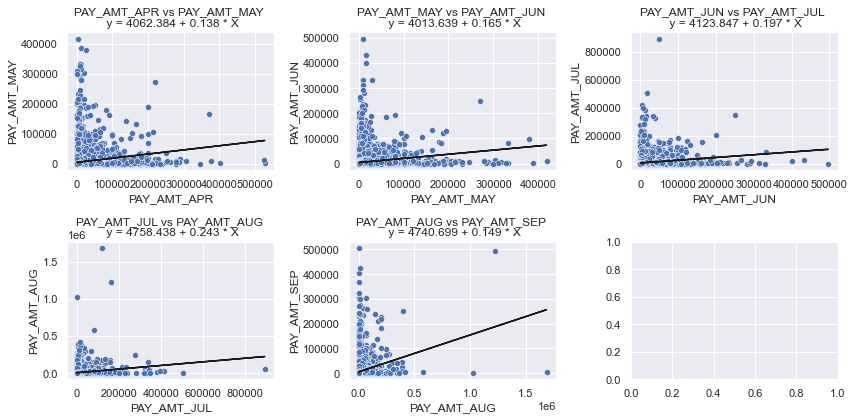

In [106]:
R_square_list = month_Correlation(X = pay_n[0:5], y = pay_n[1:6], data = train, month = 1, log_transformation = False)

In [58]:
for i in range( len(R_square_list)):
    X = bill_n[0:5]
    y = bill_n[1:6]
    print("{} vs {}:    R_square = {:.3f} \n".format(X[i], y[i], R_square_list[i]))

BILL_AMT_APR vs BILL_AMT_MAY:    R_square = 0.026 

BILL_AMT_MAY vs BILL_AMT_JUN:    R_square = 0.028 

BILL_AMT_JUN vs BILL_AMT_JUL:    R_square = 0.031 

BILL_AMT_JUL vs BILL_AMT_AUG:    R_square = 0.030 

BILL_AMT_AUG vs BILL_AMT_SEP:    R_square = 0.048 



- 데이터가 한곳에 너무 뭉쳐있으므로 log transformation을 한 후 살펴본다.

log PAY_AMT_APR vs log PAY_AMT_MAY
                            OLS Regression Results                            
Dep. Variable:            PAY_AMT_MAY   R-squared:                       0.246
Model:                            OLS   Adj. R-squared:                  0.246
Method:                 Least Squares   F-statistic:                     7829.
Date:                Tue, 01 Dec 2020   Prob (F-statistic):               0.00
Time:                        15:52:11   Log-Likelihood:                -60392.
No. Observations:               23996   AIC:                         1.208e+05
Df Residuals:                   23994   BIC:                         1.208e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          

[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.


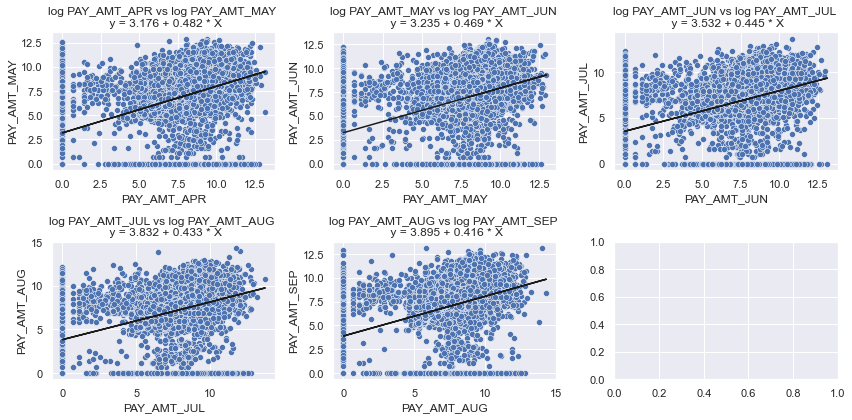

In [107]:
R_square_list = month_Correlation(X = pay_n[0:5], y = pay_n[1:6], data = train, month = 1, log_transformation = True)

In [60]:
for i in range( len(R_square_list)):
    X = bill_n[0:5]
    y = bill_n[1:6]
    print("{} vs {}:    R_square = {:.3f} \n".format(X[i], y[i], R_square_list[i]))

BILL_AMT_APR vs BILL_AMT_MAY:    R_square = 0.246 

BILL_AMT_MAY vs BILL_AMT_JUN:    R_square = 0.225 

BILL_AMT_JUN vs BILL_AMT_JUL:    R_square = 0.204 

BILL_AMT_JUL vs BILL_AMT_AUG:    R_square = 0.195 

BILL_AMT_AUG vs BILL_AMT_SEP:    R_square = 0.177 



- 데이터가 너무 넓게 퍼져 있는 것을 볼 수 있다. t-test에 의해 기울기는 유의하지만 하지만 R_square값을 보면 적합도가 매우 낮은 것을 볼 수 있다.

- Bill 값은 달과 달 사이의 값에 상관관계가 있다는 것을 볼 수 있다. 하지만 PAY_AMT값은 상관이 있다고 할 수 없다고 할 수 있다. 
- Bill 선형회귀의 기울기 추정구간이 0.95 ~ 1.0 인 것과 절편은 2000\~3000정도의 값을 갖는것을 통해 신용카드 이용고객들은 보통 전달 사용량보다 평균적으로 2000\~3000정도를 더 쓴다고 볼 수 있다.
- 이상치도 어느정도 검출해낼 수 있다.